## Importing required Libraries

In [2]:
import random # library for random number generation
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests
import json # library to handle JSON files
import bs4 as bs
import urllib.request

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

# geocoder
#!conda install -c conda-forge geopy --yes 
#import geocoder

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# use the inline backend to generate the plots within the browser
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0
print('Libraries imported.')


Matplotlib version:  2.2.2
Libraries imported.


### Assigning wikipedia Article to __*url*__

In [3]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

### Prasing table using *requests* and *BeautifulSoup*

In [4]:
req=requests.get(url)
data=req.text
    
soup = BeautifulSoup(data,"html.parser")
table = soup.table

### __*table*__ now has all the table data in wikipedia article

In [5]:
table_rows=[] # creating an empty list

#### Iterating over *'tr'* and *'td'* tags in __'table'__

When in __*'td'*__ tag, search for __*'a'*__ tag and then get the title by doing this we can filter the Grayed Out and Not Assigned cells

Grayed Out and Not Assigned cells will be replaced by __*'None'*__

Extracting table data into __*table_rows*__

In [6]:
trs=table.find_all('tr')
for tr in trs:
    td = tr.find_all('td')
    if len(td)==0:
        continue
    postal_code = td[0].getText()
    district = td[1].find('a')
    if district is None:
        dist_name = 'None'
    else:
        dist_name = district.getText() 
    Neighborhood = td[2].find('a')
    if Neighborhood is None:
        Neig_hood = 'None'
    else:
        Neig_hood = Neighborhood.getText()
    table_rows.append([postal_code,dist_name,Neig_hood])

#### Creating Dataframe from __*table_rows*__ and assigning column names

In [7]:
df=pd.DataFrame(table_rows,columns=['PostalCode','Borough','Neighborhood'])

#### Filtering the rows which has 'None'. 
'None' indicates grayed out and Not assigned cells

In [8]:
df1=df[df['Neighborhood'] != 'None']

In [9]:
df2=df1[df1['Borough'] != 'None']

In [10]:
df3=df2.reset_index()

In [11]:
df4=df3.drop('index',axis=1)

#### Below step joins values in Neighborhood column based on postalCode and Borough

In [12]:
p_codes=df4.groupby(['PostalCode','Borough'])['Neighborhood'].apply(','.join).reset_index()

In [13]:
p_codes.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [14]:
p_codes.shape

(84, 3)

In [15]:
df5=p_codes  # copying Dataframe 'P-codes' to df5

### Creating 2 functions to get Latitude and Longitude

I'm using "Geolocator" tool insted of geocoder which was given to us for sample 

I'm using Neighboorhod and Borough to get the latitude and longitude. 

In [16]:
# Function for getting Latitude
def lat(elem):
    n,b=elem
    n1=list(n.split(","))
    a='{},{}'.format(n1[0],b)
    geolocator = Nominatim()
    location = geolocator.geocode(a)
    if location == None:
        location = geolocator.geocode(b)
        latitude = location.latitude
        longitude = location.longitude
    else:
        latitude = location.latitude
        longitude = location.longitude
    return latitude

In [17]:
# Function for getting Longitude
def lng(elem):
    n,b=elem
    n1=list(n.split(","))
    a='{},{}'.format(n1[0],b)
    #print(a)
    geolocator = Nominatim()
    location = geolocator.geocode(a)
    if location == None:
        location = geolocator.geocode(b)
        latitude = location.latitude
        longitude = location.longitude
    else:
        latitude = location.latitude
        longitude = location.longitude
    return longitude

#### Applying functions and getting latittude and Longitude

In [18]:
df5['latitude'] = df5[['Neighborhood','Borough']].apply(lat,axis=1)

/home/jupyterlab/conda/lib/python3.6/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [19]:
df5['longitude'] = df5[['Neighborhood','Borough']].apply(lng,axis=1)

/home/jupyterlab/conda/lib/python3.6/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [20]:
df5.head()

,PostalCode,Borough,Neighborhood,latitude,longitude
0,M1B,Scarborough,"Rouge,Malvern",43.804930,-79.165837
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.790117,-79.173334
2,M1E,Scarborough,"Morningside,West Hill",43.782601,-79.204958
3,M1G,Scarborough,Woburn,43.759824,-79.225291
4,M1H,Scarborough,Cedarbrae,43.756467,-79.226692


In [21]:
url='https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'
skip_table = 1

# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
source = urllib.request.urlopen(url).read()
soup = bs.BeautifulSoup(source,'html.parser')

table = soup.find_all('table')[skip_table]
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    #print (tr)
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        l.append(row)

In [22]:
df1 = pd.DataFrame(l, columns=["Neighbourhood", "FM", "Census", "Population", "Land Area", "Density", "Population %", "Income", "Commuting", "Renters", "2nd Language", "2nd Language %"])

# clean up the data and dropping unwanted columns
df1 = df1[df1.Neighbourhood != 'Toronto CMA Average']
df1 = df1.drop('FM', 1)
df1 = df1.drop('Census', 1)
df1 = df1.drop('Renters', 1)

# change to the proper datatype
df1['Population'] = df1['Population'].str.replace(',','')
df1['Population'] = df1['Population'].apply(pd.to_numeric)
#print (df1.dtypes)

# display sample data
df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %
1,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese
2,Alderwood,11656,4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish
3,Alexandra Park,4355,0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese
4,Allenby,2513,0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian
5,Amesbury,17318,3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish
6,Armour Heights,4384,2.29,1914,2.0,"116,651",10.8,Russian (9.4%),09.4% Russian
7,Banbury,6641,2.72,2442,5.0,"92,319",6.1,Unspecified Chinese (5.1%),05.1% Unspecified Chinese
8,Bathurst Manor,14945,4.69,3187,12.3,"34,169",13.4,Russian (9.5%),09.5% Russian
9,Bay Street Corridor,4787,0.11,"43,518",3.0,"40,598",17.1,Mandarin (9.6%),09.6% Mandarin
10,Bayview Village,12280,4.14,"2,966",41.6,"46,752",14.4,Cantonese (8.4%),08.4% Cantonese


In [24]:
# Function for getting Latitude
def lat1(elem):
    a='{},Toronto, Ontario'.format(elem)
    b='Toronto, Ontario'
    geolocator = Nominatim(user_agent="myapp1")
    location = geolocator.geocode(a)
    if location == None:
        location = geolocator.geocode(b)
        latitude = location.latitude
        longitude = location.longitude
    else:
        latitude = location.latitude
        longitude = location.longitude
    return latitude

In [25]:
def lng1(elem):
    a='{},Toronto, Ontario'.format(elem)
    b='Toronto, Ontario'
    #print(a)
    geolocator = Nominatim(user_agent="myapp1")
    location = geolocator.geocode(a)
    if location == None:
        location = geolocator.geocode(b)
        latitude = location.latitude
        longitude = location.longitude
    else:
        latitude = location.latitude
        longitude = location.longitude
    return longitude

In [26]:
df1['Latitude'] = df1[['Neighbourhood']].apply(lat1,axis=1)

In [27]:
df1['Longitude'] = df1[['Neighbourhood']].apply(lng1,axis=1)

In [28]:
total_population = df1['Population'].sum()
#print (total_population)

# the higher populated neighbourhood will have the higher score
df1['Population Score'] = df1['Population']/total_population*100

# sort the dataframe based on the descending population score
df1 = df1.sort_values('Population Score', ascending=False)
df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score
113,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.653963,-79.387207,2.161626
170,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.653963,-79.387207,2.007928
50,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.653963,-79.387207,1.987065
86,L'Amoreaux,45862,7.15,6414,0.9,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.653963,-79.387207,1.898439
1,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.653963,-79.387207,1.845247
98,Malvern,44324,8.86,5003,1.5,"25,677",13.6,Tamil (12.2%),12.2% Tamil,43.653963,-79.387207,1.834774
168,Willowdale,43144,7.68,5618,62.3,"39,895",15.6,Cantonese (7.9%),07.9% Cantonese,43.653963,-79.387207,1.785929
44,Downsview,36613,16.13,2270,-5.0,"26,751",14.4,Italian (11.7%),11.7% Italian,43.653963,-79.387207,1.515581
108,Newtonbrook,36046,8.77,4110,0.3,"33,428",16.6,Russian (8.8%),08.8% Russian,43.653963,-79.387207,1.492110
139,Smithfield,34996,6.45,5426,-7.2,"24,387",12.8,Punjabi (11.8%),11.8% Punjabi,43.653963,-79.387207,1.448645


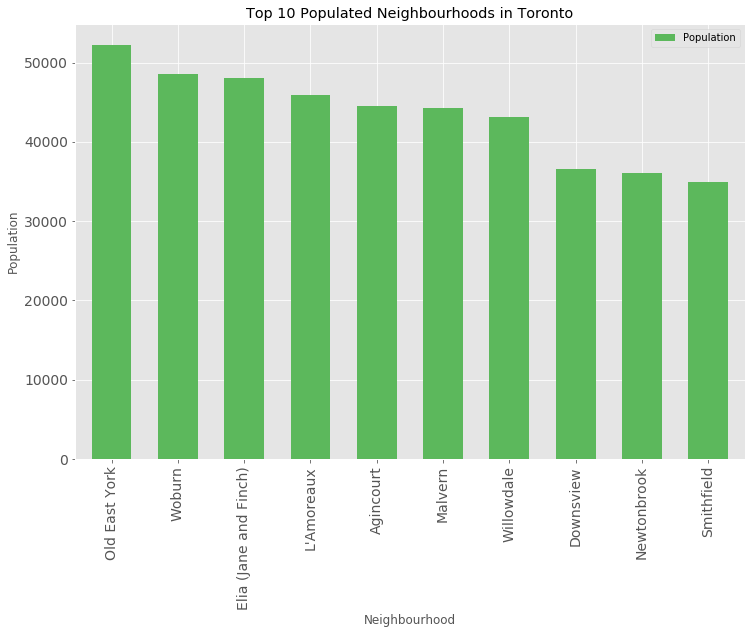

In [29]:
population_chart = df1[['Neighbourhood', 'Population']].copy()
top_chart = population_chart.head(10)
top_chart.set_index('Neighbourhood', inplace=True)

# plot data
colors = ['#5cb85c', '#5bc0de', '#d9534f']
top_chart.plot(kind='bar', figsize=(12, 8), width=0.6, fontsize=14, color=colors)

plt.xlabel('Neighbourhood') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Top 10 Populated Neighbourhoods in Toronto') # add title to the plot

plt.show()

In [30]:
# Use geopy library to get the latitude and longitude values of Toronto Ontario
address = 'Toronto Ontario, TO'
toronto_data = df1
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto Ontario are {}, {}.'.format(latitude, longitude))

/home/jupyterlab/conda/lib/python3.6/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Toronto Ontario are 14.9124059, -91.3600111.


In [31]:
map_to = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df5['latitude'], df5['longitude'], df1['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_to)  

map_to

In [32]:
# Foursquare Credentials
CLIENT_ID = 'TCIII2KKBPYXFSPVBJIBTCTGNI25UVKK5J5JRM0T4EFNWW00' # your Foursquare ID
CLIENT_SECRET = 'VPOHSUULNJORJFWFDWXS2HJWPSN51IMANSGJJQM4LVKQTXF5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: TCIII2KKBPYXFSPVBJIBTCTGNI25UVKK5J5JRM0T4EFNWW00
CLIENT_SECRET:VPOHSUULNJORJFWFDWXS2HJWPSN51IMANSGJJQM4LVKQTXF5


In [33]:
toronto_data.loc[1, 'Neighbourhood']
toronto_data.head(1)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score
113,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.653963,-79.387207,2.161626


In [34]:

neighborhood_latitude = toronto_data.loc[1, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[1, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[1, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Agincourt are 43.653963, -79.387207.


In [35]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=TCIII2KKBPYXFSPVBJIBTCTGNI25UVKK5J5JRM0T4EFNWW00&client_secret=VPOHSUULNJORJFWFDWXS2HJWPSN51IMANSGJJQM4LVKQTXF5&v=20180605&ll=43.653963,-79.387207&radius=500&limit=100'

In [36]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5bfe7167db04f56ae64ce972'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bay Street Corridor',
  'headerFullLocation': 'Bay Street Corridor, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 72,
  'suggestedBounds': {'ne': {'lat': 43.6584630045, 'lng': -79.38099903084075},
   'sw': {'lat': 43.649462995499995, 'lng': -79.39341496915925}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5227bb01498e17bf485e6202',
       'name': 'Downtown Toronto',
       'location': {'lat': 43.65323167517444,
        'lng': -79.38529600606677,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65323167517444,
          

In [37]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [38]:
# clean the json and structure it into a pandas dataframe.
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Sansotei Ramen 三草亭,Ramen Restaurant,43.655157,-79.386501
2,Textile Museum of Canada,Art Museum,43.654396,-79.386500
3,Japango,Sushi Restaurant,43.655268,-79.385165
4,Cafe Plenty,Café,43.654571,-79.389450


In [39]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

72 venues were returned by Foursquare.


In [40]:
# Explore Neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [41]:
# get scarborough venues
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude'],
                                  )

print(toronto_venues.shape)
toronto_venues.head(10)

Old East York
Woburn
Elia (Jane and Finch)
L'Amoreaux
Agincourt
Malvern
Willowdale
Downsview
Newtonbrook
Smithfield
Fairbank
Riverdale
Don Valley Village
Bendale
Parkdale
Humewood–Cedarvale
Tam O'Shanter – Sullivan
Parkwoods
Milliken
York University Heights
Richview
Scarborough Junction
West Hill
Steeles
Forest Hill
Davisville
Leslieville
High Park North
Rouge
Eglinton East
East Danforth
Don Mills
Flemingdon Park
Mount Dennis
The Beaches
Maple Leaf
Upper Beaches
Eatonville
Glen Park
Hillcrest
Thorncliffe Park
Wexford
Silverthorn
O'Connor–Parkview
Sunnylea
York Mills
Amesbury
Earlscourt
Victoria Village
Thistletown
Pleasant View
Islington – Six Points
Weston
Scarborough City Centre
Westminster
Kingsview Village
Roncesvalles
The Annex
Deer Park
Bathurst Manor
Humbermede
St. James Town
Cliffcrest
Humber Valley Village
Harbourfront / CityPlace
Mimico
Dorset Park
Leaside
Lawrence Manor
Bedford Park
Wilson Heights
Church and Wellesley
Oakridge
Bayview Woods – Steeles
Ionview
Highland Creek
G

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Old East York,43.653963,-79.387207,Downtown Toronto,43.653232,-79.385296,Neighborhood
1,Old East York,43.653963,-79.387207,Sansotei Ramen 三草亭,43.655157,-79.386501,Ramen Restaurant
2,Old East York,43.653963,-79.387207,Textile Museum of Canada,43.654396,-79.386500,Art Museum
3,Old East York,43.653963,-79.387207,Japango,43.655268,-79.385165,Sushi Restaurant
4,Old East York,43.653963,-79.387207,Cafe Plenty,43.654571,-79.389450,Café
5,Old East York,43.653963,-79.387207,Tsujiri,43.655374,-79.385354,Tea Room
6,Old East York,43.653963,-79.387207,Manpuku まんぷく,43.653612,-79.390613,Japanese Restaurant
7,Old East York,43.653963,-79.387207,Chatime 日出茶太,43.655542,-79.384684,Bubble Tea Shop
8,Old East York,43.653963,-79.387207,The Library Specialty Coffee,43.654497,-79.389723,Coffee Shop
9,Old East York,43.653963,-79.387207,Uncle Tetsu's Japanese Angel Cafe,43.655001,-79.386899,Café


In [42]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,72,72,72,72,72,72
Alderwood,72,72,72,72,72,72
Alexandra Park,72,72,72,72,72,72
Allenby,72,72,72,72,72,72
Amesbury,72,72,72,72,72,72
Armour Heights,72,72,72,72,72,72
Banbury,72,72,72,72,72,72
Bathurst Manor,72,72,72,72,72,72
Bay Street Corridor,72,72,72,72,72,72


In [43]:

print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 52 uniques categories.


In [44]:
# analyze each neighborhood

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Bar,Breakfast Spot,Bubble Tea Shop,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Cosmetics Shop,Dessert Shop,Donut Shop,Exhibit,Food Court,French Restaurant,Gastropub,Greek Restaurant,Gym,Hotel,Ice Cream Shop,Indian Restaurant,Japanese Restaurant,Jazz Club,Korean Restaurant,Miscellaneous Shop,Monument / Landmark,Movie Theater,Neighborhood,Office,Opera House,Park,Plaza,Poke Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Salon / Barbershop,Seafood Restaurant,Smoke Shop,Steakhouse,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Toy / Game Store,University,Vegetarian / Vegan Restaurant
0,Old East York,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Old East York,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Old East York,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Old East York,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Old East York,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
toronto_onehot.shape

(12528, 53)

In [47]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head(10)

,Neighbourhood,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Bar,Breakfast Spot,Bubble Tea Shop,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Cosmetics Shop,Dessert Shop,Donut Shop,Exhibit,Food Court,French Restaurant,Gastropub,Greek Restaurant,Gym,Hotel,Ice Cream Shop,Indian Restaurant,Japanese Restaurant,Jazz Club,Korean Restaurant,Miscellaneous Shop,Monument / Landmark,Movie Theater,Neighborhood,Office,Opera House,Park,Plaza,Poke Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Salon / Barbershop,Seafood Restaurant,Smoke Shop,Steakhouse,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Toy / Game Store,University,Vegetarian / Vegan Restaurant
0,Agincourt,0.027778,0.055556,0.013889,0.013889,0.013889,0.027778,0.041667,0.013889,0.055556,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.041667,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889
1,Alderwood,0.027778,0.055556,0.013889,0.013889,0.013889,0.027778,0.041667,0.013889,0.055556,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.041667,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889
2,Alexandra Park,0.027778,0.055556,0.013889,0.013889,0.013889,0.027778,0.041667,0.013889,0.055556,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.041667,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889
3,Allenby,0.027778,0.055556,0.013889,0.013889,0.013889,0.027778,0.041667,0.013889,0.055556,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.041667,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889
4,Amesbury,0.027778,0.055556,0.013889,0.013889,0.013889,0.027778,0.041667,0.013889,0.055556,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.041667,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889
5,Armour Heights,0.027778,0.055556,0.013889,0.013889,0.013889,0.027778,0.041667,0.013889,0.055556,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.041667,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889
6,Banbury,0.027778,0.055556,0.013889,0.013889,0.013889,0.027778,0.041667,0.013889,0.055556,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,

In [48]:
toronto_grouped.shape

(174, 53)

In [49]:
# print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    #print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

In [51]:
# sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
toronto_grouped.shape[0]
toronto_grouped.head()

,Neighbourhood,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Bar,Breakfast Spot,Bubble Tea Shop,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Concert Hall,Cosmetics Shop,Dessert Shop,Donut Shop,Exhibit,Food Court,French Restaurant,Gastropub,Greek Restaurant,Gym,Hotel,Ice Cream Shop,Indian Restaurant,Japanese Restaurant,Jazz Club,Korean Restaurant,Miscellaneous Shop,Monument / Landmark,Movie Theater,Neighborhood,Office,Opera House,Park,Plaza,Poke Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Salon / Barbershop,Seafood Restaurant,Smoke Shop,Steakhouse,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Toy / Game Store,University,Vegetarian / Vegan Restaurant
0,Agincourt,0.027778,0.055556,0.013889,0.013889,0.013889,0.027778,0.041667,0.013889,0.055556,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.041667,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889
1,Alderwood,0.027778,0.055556,0.013889,0.013889,0.013889,0.027778,0.041667,0.013889,0.055556,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.041667,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889
2,Alexandra Park,0.027778,0.055556,0.013889,0.013889,0.013889,0.027778,0.041667,0.013889,0.055556,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.041667,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889
3,Allenby,0.027778,0.055556,0.013889,0.013889,0.013889,0.027778,0.041667,0.013889,0.055556,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.041667,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889
4,Amesbury,0.027778,0.055556,0.013889,0.013889,0.013889,0.027778,0.041667,0.013889,0.055556,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.055556,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.041667,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889


In [53]:
# create the new dataframe and display the top 8 venues for each neighborhood.
num_top_venues = 8

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Agincourt,Japanese Restaurant,Art Gallery,Café,Coffee Shop,Breakfast Spot,Sushi Restaurant,Hotel,Bar
1,Alderwood,Japanese Restaurant,Art Gallery,Café,Coffee Shop,Breakfast Spot,Sushi Restaurant,Hotel,Bar
2,Alexandra Park,Japanese Restaurant,Art Gallery,Café,Coffee Shop,Breakfast Spot,Sushi Restaurant,Hotel,Bar
3,Allenby,Japanese Restaurant,Art Gallery,Café,Coffee Shop,Breakfast Spot,Sushi Restaurant,Hotel,Bar
4,Amesbury,Japanese Restaurant,Art Gallery,Café,Coffee Shop,Breakfast Spot,Sushi Restaurant,Hotel,Bar
5,Armour Heights,Japanese Restaurant,Art Gallery,Café,Coffee Shop,Breakfast Spot,Sushi Restaurant,Hotel,Bar
6,Banbury,Japanese Restaurant,Art Gallery,Café,Coffee Shop,Breakfast Spot,Sushi Restaurant,Hotel,Bar
7,Bathurst Manor,Japanese Restaurant,Art Gallery,Café,Coffee Shop,Breakfast Spot,Sushi Restaurant,Hotel,Bar
8,Bay Street Corridor,Japanese Restaurant,Art Gallery,Café,Coffee Shop,Breakfast Spot,Sushi Restaurant,Hotel,Bar
9,Bayview Village,Japanese Restaurant,Art Gallery,Café,Coffee Shop,Breakfast Spot,Sushi Restaurant,Hotel,Bar


In [54]:
neighborhoods_venues_sorted['Venue Score'] = 0
venue = 'Park'
venue_count = 0

# award the score based on the common findings
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['1st Most Common Venue'].str.contains(venue), ['Venue Score']] = 1.0
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['2nd Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.9
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['3rd Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.8
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['4th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.7
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['5th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.6
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['6th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.5
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['7th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.4
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['8th Most Common Venue'].str.contains(venue), ['Venue Score']] = 0.3

# merge the two dataframes
merged_data = pd.merge(df1, neighborhoods_venues_sorted, on='Neighbourhood')

# clean up the merged dataset
merged_data = merged_data.drop('1st Most Common Venue', 1)
merged_data = merged_data.drop('2nd Most Common Venue', 1)
merged_data = merged_data.drop('3rd Most Common Venue', 1)
merged_data = merged_data.drop('4th Most Common Venue', 1)
merged_data = merged_data.drop('5th Most Common Venue', 1)
merged_data = merged_data.drop('6th Most Common Venue', 1)
merged_data = merged_data.drop('7th Most Common Venue', 1)
merged_data = merged_data.drop('8th Most Common Venue', 1)
neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Venue Score', 1)

merged_data.head(10)

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score
0,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.653963,-79.387207,2.161626,0.0
1,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.653963,-79.387207,2.007928,0.0
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.653963,-79.387207,1.987065,0.0
3,L'Amoreaux,45862,7.15,6414,0.9,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.653963,-79.387207,1.898439,0.0
4,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.653963,-79.387207,1.845247,0.0
5,Malvern,44324,8.86,5003,1.5,"25,677",13.6,Tamil (12.2%),12.2% Tamil,43.653963,-79.387207,1.834774,0.0
6,Willowdale,43144,7.68,5618,62.3,"39,895",15.6,Cantonese (7.9%),07.9% Cantonese,43.653963,-79.387207,1.785929,0.0
7,Downsview,36613,16.13,2270,-5.0,"26,751",14.4,Italian (11.7%),11.7% Italian,43.653963,-79.387207,1.515581,0.0
8,Newtonbrook,36046,8.77,4110,0.3,"33,428",16.6,Russian (8.8%),08.8% Russian,43.653963,-79.387207,1.492110,0.0
9,Smithfield,34996,6.45,5426,-7.2,"24,387",12.8,Punjabi (11.8%),11.8% Punjabi,43.653963,-79.387207,1.448645,0.0


In [55]:
# considering this to be a fair weightage on both parameters
population_weight = 0.5
venue_weight = 0.5

# calculate the total score
merged_data['Total Score'] = (merged_data['Population Score']*population_weight) + (merged_data['Venue Score']*venue_weight)

# sort the dataframe based on the descending total score
merged_data = merged_data.sort_values('Total Score', ascending=False)

In [56]:
# set number of clusters
kclusters = 5

#toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# clean up data further
toronto_grouped_clustering = merged_data.drop('Neighbourhood', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Income', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('Density', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('2nd Language', 1)
toronto_grouped_clustering = toronto_grouped_clustering.drop('2nd Language %', 1)

toronto_grouped_clustering.head(10)

,Population,Land Area,Population %,Commuting,Latitude,Longitude,Population Score,Venue Score,Total Score
0,52220,7.94,-4.6,22.0,43.653963,-79.387207,2.161626,0.0,1.080813
1,48507,13.34,-1.5,13.3,43.653963,-79.387207,2.007928,0.0,1.003964
2,48003,7.66,-10.0,13.0,43.653963,-79.387207,1.987065,0.0,0.993533
3,45862,7.15,0.9,13.4,43.653963,-79.387207,1.898439,0.0,0.949220
4,44577,12.45,4.6,11.1,43.653963,-79.387207,1.845247,0.0,0.922624
5,44324,8.86,1.5,13.6,43.653963,-79.387207,1.834774,0.0,0.917387
6,43144,7.68,62.3,15.6,43.653963,-79.387207,1.785929,0.0,0.892964
7,36613,16.13,-5.0,14.4,43.653963,-79.387207,1.515581,0.0,0.757790
8,36046,8.77,0.3,16.6,43.653963,-79.387207,1.492110,0.0,0.746055
9,34996,6.45,-7.2,12.8,43.653963,-79.387207,1.448645,0.0,0.724323


In [64]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 3, 3, 3, 3, 1, 1, 1], dtype=int32)

In [65]:
# empty the invalid data
#merged_data['Neighbourhood'] = neighborhoods_venues_sorted['Neighbourhood']
#print(toronto_data.shape)
merged_data.isnull().sum()
merged_data.dropna(how = 'any', axis = 0, inplace = True)
print(merged_data.shape)
print(neighborhoods_venues_sorted.shape)

(174, 14)
(174, 9)


In [66]:
merged_data.head()

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score
0,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.653963,-79.387207,2.161626,0.0,1.080813
1,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.653963,-79.387207,2.007928,0.0,1.003964
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.653963,-79.387207,1.987065,0.0,0.993533
3,L'Amoreaux,45862,7.15,6414,0.9,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.653963,-79.387207,1.898439,0.0,0.949220
4,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.653963,-79.387207,1.845247,0.0,0.922624


In [67]:
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Venue Score', 1)
neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Agincourt,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
1,Alderwood,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
2,Alexandra Park,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
3,Allenby,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
4,Amesbury,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant


In [68]:
toronto_merged = toronto_data

# add clustering labels
merged_data['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = merged_data.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.653963,-79.387207,2.161626,0.0,1.080813,3,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
1,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.653963,-79.387207,2.007928,0.0,1.003964,3,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.653963,-79.387207,1.987065,0.0,0.993533,3,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
3,L'Amoreaux,45862,7.15,6414,0.9,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.653963,-79.387207,1.898439,0.0,0.949220,3,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
4,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.653963,-79.387207,1.845247,0.0,0.922624,3,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant


In [69]:
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [70]:
# display the top 5 neighbourhoods
target = merged_data.head(5)
target.head()
#toronto_merged.loc[toronto_merged['Cluster Labels'] == 0].count()

,Neighbourhood,Population,Land Area,Density,Population %,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels
0,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,43.653963,-79.387207,2.161626,0.0,1.080813,3
1,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.653963,-79.387207,2.007928,0.0,1.003964,3
2,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.653963,-79.387207,1.987065,0.0,0.993533,3
3,L'Amoreaux,45862,7.15,6414,0.9,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.653963,-79.387207,1.898439,0.0,0.949220,3
4,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.653963,-79.387207,1.845247,0.0,0.922624,3


In [71]:
# Cluster 1 
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

,Neighbourhood,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
27,High Park North,22746,"46,437",27.5,Polish (3.0%),03.0% Polish,43.653963,-79.387207,0.941562,0.0,0.470781,0,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
28,Rouge,22724,"29,230",12.1,Tamil (15.6%),15.6% Tamil,43.653963,-79.387207,0.940651,0.0,0.470325,0,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
29,Eglinton East,22387,"25,307",19.4,Tamil (9.7%),09.7% Tamil,43.653963,-79.387207,0.926701,0.0,0.463350,0,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
30,East Danforth,21440,"33,847",24.2,Cantonese (4.2%),04.2% Cantonese,43.653963,-79.387207,0.887500,0.0,0.443750,0,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
31,Don Mills,21372,"47,515",10.8,Unspecified Chinese (3.9%),03.9% Unspecified Chinese,43.653963,-79.387207,0.884685,0.0,0.442343,0,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant


In [72]:

# Cluster 2 
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

,Neighbourhood,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
7,Downsview,36613,"26,751",14.4,Italian (11.7%),11.7% Italian,43.653963,-79.387207,1.515581,0.0,0.757790,1,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
8,Newtonbrook,36046,"33,428",16.6,Russian (8.8%),08.8% Russian,43.653963,-79.387207,1.492110,0.0,0.746055,1,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
9,Smithfield,34996,"24,387",12.8,Punjabi (11.8%),11.8% Punjabi,43.653963,-79.387207,1.448645,0.0,0.724323,1,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
10,Fairbank,34121,"28,403",21.6,Portuguese (11.3%),11.3% Portuguese,43.653963,-79.387207,1.412425,0.0,0.706213,1,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
11,Riverdale,31007,"40,139",20.0,Cantonese (6.7%),06.7% Cantonese,43.653963,-79.387207,1.283522,0.0,0.641761,1,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant


In [73]:
# Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

,Neighbourhood,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
120,Rosedale,7672,"213,941",11.3,Unspecified Chinese (1.0%),01.0% Unspecified Chinese,43.653963,-79.387207,0.317579,0.0,0.158790,2,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
121,Humberwood,7319,"29,576",7.9,Punjabi (26.7%),26.7% Punjabi,43.653963,-79.387207,0.302967,0.0,0.151484,2,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
122,Discovery District,7262,"41,998",12.7,Unspecified Chinese (6.5%),06.5% Unspecified Chinese,43.653963,-79.387207,0.300608,0.0,0.150304,2,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
123,Junction Triangle,6666,"28,067",20.0,Portuguese (13.0%),13.0% Portuguese,43.653963,-79.387207,0.275936,0.0,0.137968,2,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
124,Lawrence Park,6653,"214,110",8.3,French (0.8%),00.8% French,43.653963,-79.387207,0.275398,0.0,0.137699,2,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant


In [75]:
# Cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

,Neighbourhood,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Old East York,52220,"33,172",22.0,Greek (4.3%),04.3% Greek,43.653963,-79.387207,2.161626,0.0,1.080813,3,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
1,Woburn,48507,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,43.653963,-79.387207,2.007928,0.0,1.003964,3,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
2,Elia (Jane and Finch),48003,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,43.653963,-79.387207,1.987065,0.0,0.993533,3,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
3,L'Amoreaux,45862,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,43.653963,-79.387207,1.898439,0.0,0.949220,3,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
4,Agincourt,44577,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,43.653963,-79.387207,1.845247,0.0,0.922624,3,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant


In [76]:
# Cluster 5
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]].sort_values('Population Score', ascending=False).head(5)

,Neighbourhood,Population,Income,Commuting,2nd Language,2nd Language %,Latitude,Longitude,Population Score,Venue Score,Total Score,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
63,Humber Valley Village,14453,"80,618",12.0,Ukrainian (3.9%),03.9% Ukrainian,43.653963,-79.387207,0.598276,0.0,0.299138,4,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
64,Harbourfront / CityPlace,14368,"69,232",16.0,Unspecified Chinese (2.4%),02.4% Unspecified Chinese,43.653963,-79.387207,0.594758,0.0,0.297379,4,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
65,Mimico,14198,"47,011",11.6,Polish (3.6%),03.6% Polish,43.653963,-79.387207,0.587721,0.0,0.293860,4,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
66,Dorset Park,14189,"26,525",15.2,Tamil (9.5%),09.5% Tamil,43.653963,-79.387207,0.587348,0.0,0.293674,4,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant
67,Leaside,13876,"82,670",9.7,Bulgarian (0.4%),00.4% Bulgarian,43.653963,-79.387207,0.574391,0.0,0.287196,4,Art Gallery,Japanese Restaurant,Coffee Shop,Café,Breakfast Spot,Bar,Chinese Restaurant,American Restaurant


### Final Results

Based on the result above, the first cluster looks to offer a higher number of similar neighborhoods that has more Indian population(more specificly south Indians_Tamil) 

Within the first cluster, we will like to recommend a neighborhood with higher demand and lower supply to give ABC Resturant a higher advantage and chance to succeed upon their first service offering. Hence, with this in mind, it is apparent that neighborhood __*'Rouge'*__ looks to be the choice as it is the highest tamil populated and very few indian resturants in the neighborhood (i.e. close to none for the first few most common venues in this neighborhood).

It is also apparent that there is a high number of tamil  people in that neighborhood and hence, we will also like to encourage the management of ABC resturant to offer Tamil food or related Groceies shop

With that, we have concluded that the best recommendation for ABC resturant to first offer their services in Toronto will be neighborhood __*'Rouge'*__ with the key factors to consider such as higher demand, lower competition, easy replication for business expansion. See the recommendation summary below.

Region: First Cluster.
Neighborhood: __*'Rouge'*__
Additional Offering: Punjabi food or related supplies.